<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 44 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Y          1111 non-null   int64  
 1   Data       1111 non-null   object 
 2   XAU BGNL   1111 non-null   float64
 3   ECSURPUS   1111 non-null   float64
 4   BDIY       1111 non-null   int64  
 5   CRY        1111 non-null   float64
 6   DXY        1111 non-null   float64
 7   JPY        1111 non-null   float64
 8   GBP        1111 non-null   float64
 9   Cl1        1111 non-null   float64
 10  VIX        1111 non-null   float64
 11  USGG30YR   1111 non-null   float64
 12  GT10       1111 non-null   float64
 13  USGG2YR    1111 non-null   float64
 14  USGG3M     1111 non-null   float64
 15  US0001M    1111 non-null   float64
 16  GTDEM30Y   1111 non-null   float64
 17  GTDEM10Y   1111 non-null   float64
 18  GTDEM2Y    1111 non-null   float64
 19  EONIA      1111 non-null   float64
 20  GTITL30Y

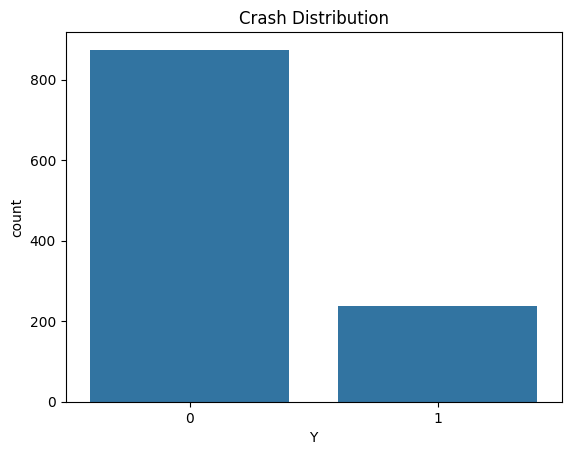

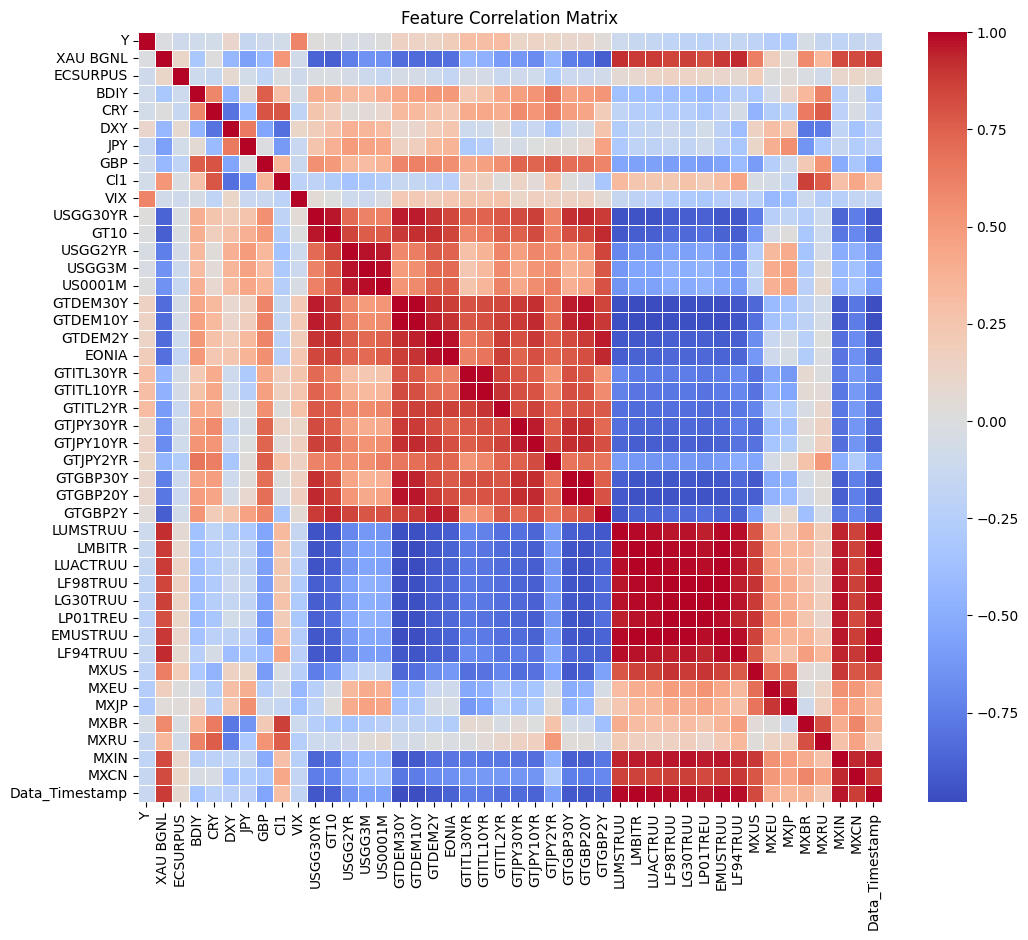

Selected Features (Sorted by Correlation):
VIX     0.598432
DXY     0.103227
GT10   -0.004776
Cl1    -0.070141
CRY    -0.074102
BDIY   -0.083440
dtype: float64


In [155]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
import seaborn as sns
from imblearn.over_sampling import SMOTE
import warnings as wr
wr.filterwarnings('ignore')


# Load dataset
data = pd.read_csv('market_data.csv')

# Dataset info
print(data.info())
print(data.shape)
print(data.describe())

# Plot target variable
sns.countplot(x='Y', data=data)
plt.title('Crash Distribution')
plt.show()

# Convert date to int
data['Data'] = pd.to_datetime(data['Data'])
data['Data_Timestamp'] = data['Data'].astype('int64') // 10**9

# Correlation matrix
numerical_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

# Selected features
selected_features = ['VIX', 'DXY', 'GT10', 'Cl1', 'CRY', 'BDIY']

# Correlation with target
correlation_with_target = data[selected_features].corrwith(data['Y'])
print("Selected Features (Sorted by Correlation):")
print(correlation_with_target.sort_values(ascending=False))

# Split data
split_index = int(len(data) * 0.8)  # 80% for training
train_data = data.iloc[:split_index]  # Training data
test_data = data.iloc[split_index:]  # Testing data

# Feature engineering (rolling calculations)
train_data['VIX_rolling_mean'] = train_data['VIX'].rolling(window=5, min_periods=1).mean()
train_data['VIX_rolling_std'] = train_data['VIX'].rolling(window=5, min_periods=1).std()
test_data['VIX_rolling_mean'] = test_data['VIX'].rolling(window=5, min_periods=1).mean()
test_data['VIX_rolling_std'] = test_data['VIX'].rolling(window=5, min_periods=1).std()

# Update selected features
selected_features += ['VIX_rolling_mean', 'VIX_rolling_std']

# Ensure no NaN values after rolling calculations
train_data = train_data.dropna()
test_data = test_data.dropna()

# Features and labels
X_train = train_data[selected_features]
y_train = train_data['Y']
X_test = test_data[selected_features]
y_test = test_data['Y']

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [156]:
# Train Logistic Regression model
lr_model = LogisticRegression(
    random_state=42,
    penalty='l1',
    solver='liblinear',
    class_weight='balanced'
)

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)
y_prob = lr_model.predict_proba(X_test)[:, 1]

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       193
           1       0.38      0.90      0.53        29

    accuracy                           0.79       222
   macro avg       0.68      0.84      0.70       222
weighted avg       0.90      0.79      0.82       222

ROC-AUC Score: 0.9224584598892265


In [157]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    class_weight='balanced',
    min_samples_leaf=40,
    min_samples_split=10,
    max_depth=None,
    n_estimators=100
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       193
           1       0.32      0.83      0.47        29

    accuracy                           0.75       222
   macro avg       0.65      0.78      0.65       222
weighted avg       0.88      0.75      0.79       222

ROC-AUC Score: 0.89047704127211


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       193
           1       0.41      0.83      0.55        29

    accuracy                           0.82       222
   macro avg       0.69      0.82      0.72       222
weighted avg       0.90      0.82      0.84       222

ROC-AUC Score: 0.8558156155083081


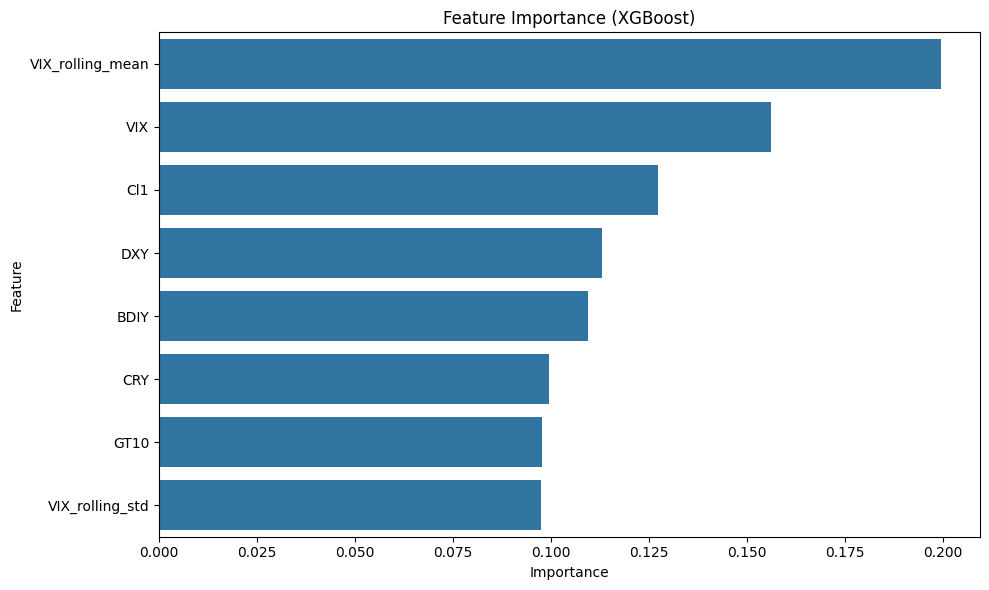

['xgb_model.pkl']

In [158]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    random_state=42,
    n_estimators=150,
    max_depth=10,
    learning_rate=0.3,
    subsample=0.3,
    colsample_bytree=0.9
  )

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# Feature importance
importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Save the trained model to a file
joblib.dump(xgb_model, 'xgb_model.pkl')

In [159]:
# Train Isolation Forest model
isolation_forest = IsolationForest(
    n_estimators=100,          # Number of trees
    max_samples='auto',        # Number of samples per tree
    contamination=0.27,        # Proportion of outliers
    random_state=42,           # For reproducibility
)

# Fit the model on training data
isolation_forest.fit(X_train)

# Predict anomalies (-1 for anomaly, 1 for normal)
y_pred_test = isolation_forest.predict(X_test)

# Map predictions: -1 (anomaly) → 1 (anomaly), 1 (normal) → 0 (normal)
y_pred_test = np.where(y_pred_test == -1, 1, 0)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# ROC-AUC score
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.38      0.54       193
           1       0.17      0.86      0.29        29

    accuracy                           0.44       222
   macro avg       0.56      0.62      0.41       222
weighted avg       0.85      0.44      0.51       222

ROC-AUC Score: 0.6201536537430766
